In [4]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Global: Define which day the dataset starts on (0 = Monday)
WEEK_START_DAY = 0

In [ ]:
# Cell 2: Load and parse CSV
# Replace with your actual file path
df = pd.read_csv("bbr esmond data ap-ba 07-13-2024.csv")

df['Data'] = pd.to_datetime(df['Data'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
df.drop(columns=['Timestamp'], inplace = True)

# Sort by time just in case
df = df.sort_values('Data').reset_index(drop=True)

df.head()


,Data,Vazao
0,2024-01-15 15:45:30,884736884.0
1,2024-01-15 21:10:11,919615275.0
2,2024-01-16 08:17:47,932835005.0
3,2024-01-16 12:15:35,913626050.0
4,2024-01-16 14:56:31,935871393.0


In [12]:
# Cell 3: Resample to 6-hour intervals (if needed)
# If data already has 6-hour intervals, this step just revalidates
df.set_index('Data', inplace=True)

df_resampled = df.resample('6H').mean()  # or use 'max', 'first' etc. depending on logic
df_resampled = df_resampled.reset_index()

df_resampled.head(10)


/tmp/ipykernel_4280/4019447332.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('6H').mean()  # or use 'max', 'first' etc. depending on logic


,Data,Vazao
0,2024-01-15 12:00:00,884736884.0
1,2024-01-15 18:00:00,919615275.0
2,2024-01-16 00:00:00,NaN
3,2024-01-16 06:00:00,932835005.0
4,2024-01-16 12:00:00,924748721.5
5,2024-01-16 18:00:00,919815857.0
6,2024-01-17 00:00:00,NaN
7,2024-01-17 06:00:00,920912286.0
8,2024-01-17 12:00:00,921494302.0
9,2024-01-17 18:00:00,NaN


In [13]:
# Cell 4: Create time-based features
df_feat = df_resampled.copy()

# Preserve raw throughput
df_feat['throughput_raw'] = df_feat['Vazao']

df_feat['hour'] = df_feat['Data'].dt.hour
df_feat['day_of_week'] = df_feat['Data'].dt.dayofweek

# Adjust based on global week start
df_feat['relative_day'] = ((df_feat['day_of_week'] - WEEK_START_DAY) % 7)
df_feat['is_weekend'] = df_feat['relative_day'] >= 5

# Continuous time since beginning (for drift learning)
df_feat['time_since_start'] = (df_feat['Data'] - df_feat['Data'].min()).dt.total_seconds() / 3600.0

# Encode cyclical time features
df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)


In [15]:
# Cell 5: Add rolling statistics
ROLLING_WINDOW = 4  # 4 intervals = 1 day (6h * 4)

df_feat['throughput_rolling_mean'] = df_feat['Vazao'].rolling(window=ROLLING_WINDOW, min_periods=1).mean()
df_feat['throughput_rolling_std'] = df_feat['Vazao'].rolling(window=ROLLING_WINDOW, min_periods=1).std()

# Optional: Fill NaNs from std with 0 if needed
df_feat['throughput_rolling_std'] = df_feat['throughput_rolling_std'].fillna(0)


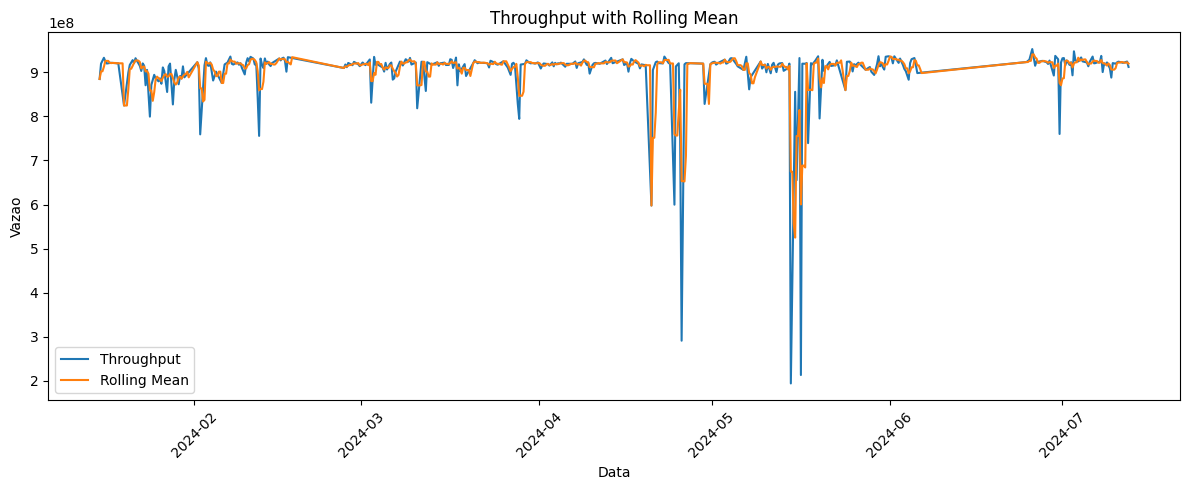

In [18]:
# Cell 6: Display processed dataset
import seaborn as sns
import matplotlib.pyplot as plt

# Simple plot to visualize rolling features
plt.figure(figsize=(12, 5))
sns.lineplot(x="Data", y="Vazao", data=df_feat, label="Throughput")
sns.lineplot(x="Data", y="throughput_rolling_mean", data=df_feat, label="Rolling Mean")
plt.xticks(rotation=45)
plt.legend()
plt.title("Throughput with Rolling Mean")
plt.tight_layout()
plt.show()

df_feat.head(15)
df_feat.to_csv("teste.csv")
